#Deep learning


In [1]:
!pip install torch torchvision

In [2]:
!wget http://deeplearning.iit.bme.hu/CVS/trafficSignsHW.zip
!unzip -qq trafficSignsHW.zip
!rm trafficSignsHW.zip


--2021-09-03 20:03:44--  http://deeplearning.iit.bme.hu/CVS/trafficSignsHW.zip
Resolving deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)... 152.66.243.112
Connecting to deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)|152.66.243.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175675617 (168M) [application/zip]
Saving to: ‘trafficSignsHW.zip’

trafficSignsHW.zip  100%[===================>] 167.54M  6.43MB/s    in 28s     

2021-09-03 20:04:12 (6.04 MB/s) - ‘trafficSignsHW.zip’ saved [175675617/175675617]



## Creating a Neural network model
### Define Convolutional block

In [3]:
!nvidia-smi

Fri Sep  3 20:04:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import torch
import torch.nn as nn

# Convolutional module (Conv+ReLU+BatchNorm)
class Conv(nn.Module):
    # Constructor gets in and output channels and stride
    def __init__(self,in_channels,channels,size=3,stride=1):
      super().__init__()
      self.conv=nn.Conv2d(in_channels,channels,kernel_size=size,stride=stride,padding=size//2,bias=False)
      self.bn=nn.BatchNorm2d(channels)
    # Overwrite forward
    def forward(self,x):
      return self.bn(torch.relu(self.conv(x)))

### Create neural network

In [5]:
class ConvNet(nn.Module):
    
    # Constructor gets channel number of the image and the first filte
    def __init__(self,base_channels=16,in_channels=3,num_classes=52):
      super().__init__()


      self.c11=Conv(in_channels,base_channels)
      self.c12=Conv(base_channels,base_channels)
      self.d1=Conv(base_channels,base_channels*2,stride=2)

        # Repeat this 4 times
      self.c21=Conv(base_channels*2,base_channels*2)
      self.c22=Conv(base_channels*2,base_channels*2)
      self.d2=Conv(base_channels*2,base_channels*4,stride=2)

        # Repeat this 4 times
      self.c31=Conv(base_channels*4,base_channels*4)
      self.c32=Conv(base_channels*4,base_channels*4)
      self.d3=Conv(base_channels*4,base_channels*8,stride=2)

        # Repeat this 4 times
      self.c41=Conv(base_channels*8,base_channels*8)
      self.c42=Conv(base_channels*8,base_channels*8)
      self.d4=Conv(base_channels*8,base_channels*16,stride=2)

        # Repeat this 4 times
      self.c51=Conv(base_channels*16,base_channels*16)
      self.c52=Conv(base_channels*16,base_channels*16)
      self.d5=Conv(base_channels*16,base_channels*32,stride=2)

        # Input image is 32x32 -> after 5 downscaling the activation map is 1x1
        
        # Classifier is a normal 1x1 convolution that produces num_classes class scores
        # This layer does not have BatchNorm of ReLU
      self.classifier = nn.Conv2d(base_channels*32,num_classes,1)

    def forward(self,x):
        # Class all the layers
        x=self.d1(  self.c12( self.c11(x) ) )
        x=self.d2(  self.c22( self.c21(x) ) )
        x=self.d3(  self.c32( self.c31(x) ) )
        x=self.d4(  self.c42( self.c41(x) ) )
        x=self.d5(  self.c52( self.c51(x) ) )
        # Squeeze removes dimensions that have only 1 element
        # Output of the conv layer is (batch_size x num_classes x 1 x 1)
        # After squeeze is becomes (batch_size x num_classes)
        return torch.squeeze(self.classifier(x))

## Setup Learning
### Check GPU Availability

In [6]:
haveCuda = torch.cuda.is_available()
print(haveCuda)

True


### Data Augmentation

In [7]:
from torchvision import transforms

# Necessary transformations: conversion to PyTorch Tensor and normalization
# Normalization is performed with channels-wise means and variances computed on ImageNet
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                         (0.24703233, 0.24348505, 0.26158768))
])

# Train database transform includes data augmentation
transform = transforms.Compose([
    # Random 32x32 crops (with 4-wide zero padding - this is needed because the 
    # input is 32x32 so we can't crop a 32x32 region out of it without padding)
    # Flips horizontally with p=0.5
    # Random perturbance of brightness, contrast and color
    transforms.RandomCrop(32,padding=4),
   
    transforms.ColorJitter(brightness=0.3,contrast=0.3,saturation=0.3,hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                         (0.24703233, 0.24348505, 0.26158768))
])

### Datasets

In [8]:
import torchvision
# Trainsets automatically download the dataset if not present
trainSet = torchvision.datasets.ImageFolder(root="/content/trafficSignsHW/trainFULL",transform=transform)
testSet = torchvision.datasets.ImageFolder(root="/content/trafficSignsHW/testFULL",transform=transform_val)

### Dataloaders

In [9]:
# Dataloaders are responsible for giving random (if shuffle is true) minibatches
trainLoader=torch.utils.data.DataLoader(trainSet,batch_size=128,shuffle=True)
testLoader=torch.utils.data.DataLoader(testSet,batch_size=128,shuffle=False)

### Create Network

In [10]:
# Instantiate network and convert it to CUDA
import copy
def createNet():
  model=ConvNet()
  if(haveCuda):
    model=model.cuda()
   
  return model

### Create Loss

In [11]:
# We use cros entropy, since CIFAR10 is a classification set
def createLoss():
  return nn.CrossEntropyLoss()

### Create optimizer

In [12]:
from torch import optim

# Stochastic Gradient Descent (SGD) optimizer with Nesterov momentum and 0.1 learning rate
# Weight decay is the relative weight of the L2 regularization term
def createOptimizer():
  return optim.SGD(model.parameters(),lr=1e-1,momentum=0.9,nesterov=True,weight_decay=1e-4)

### Create Learning Rate Scheduler

In [13]:
# Run for 50 epochs - 1 epoch means the networks sees every training image once
numEpoch =15

# Cosine annealing learning rate scheduler - in 50 epochs the lr will become 0.01
def createScheduler():
  return optim.lr_scheduler.CosineAnnealingLR(optimizer,numEpoch,eta_min=1e-2)

## Epoch Functions
### Progress bar

In [14]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

### Train

In [15]:
# Function for training a single epch
def train(epoch):

    # variables for loss
    running_loss = 0.0
    correct = 0.0
    total = 0

    # set the network to train (for batchnorm and dropout)
    model.train()
    # Create progress bar
    bar = display(progress(0, len(trainLoader)), display_id=True)

    # data will contain one minibatch of images and correcponding labels
    # When the iteration is finished we have seen every training image once
    for i, data in enumerate(trainLoader, 0):
        # get the inputs
        images,labels = data
        
        # Convert to cuda
        if haveCuda:
          images,labels = images.cuda(),labels.cuda()

        # Clear any previous gradients
        optimizer.zero_grad()

        # Forward
        outputs=model(images)

        # Loss
        loss=criterion(outputs,labels)

        # Backpropagation
        loss.backward()

        # Gradient method
        optimizer.step()

        # Do not include these steps in the computational graph
        with torch.no_grad():
            # Accumulate loss
            running_loss += loss.item()

            # Get indices of the largest goodness values
            _,predicted=torch.max(outputs,1)

            # Count how many of the predictions equal the labels
            correct+=(predicted==labels).sum().item()

            # Accumulate number of total images seen
            total+=labels.shape[0]

        # Progress bar
        bar.update(progress(i+1, len(trainLoader)))

    # return loss and accuracy
    tr_loss = running_loss / i
    tr_corr = correct / total * 100
    print("Train epoch %d loss: %.3f correct: %.2f" % (epoch + 1, running_loss / i, tr_corr))
    return tr_loss,tr_corr

### Validation

In [16]:
# Function for validating a single epch
def val(epoch):

    # variables for loss
    running_loss = 0.0
    correct = 0.0
    total = 0

    conf =torch.zeros((52,52))
    # set the network to eval  (for batchnorm and dropout)
    model.eval()

    # Create progress bar
    bar = display(progress(0, len(testLoader)), display_id=True)

    for i, data in enumerate(testLoader, 0):
        # get the inputs
        inputs, labels = data

        # Convert to cuda
        if haveCuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        # Do not include these steps in the computational graph
        with torch.no_grad():
          outputs=model(inputs)
          # Loss
          loss=criterion(outputs,labels)
          # Compute statistics, just like before
          # Accumulate loss
          running_loss += loss.item()
          # Get indices of the largest goodness values
          _,predicted=torch.max(outputs,1)
          # Count how many of the predictions equal the labels
          correct+=(predicted==labels).sum().item()
          # Accumulate number of total images seen
          total+=labels.shape[0]
          for p,l in zip(predicted,labels):
            conf[p,l]+=1

        bar.update(progress(i+1, len(testLoader)))

    # return loss and accuracy
    val_loss = running_loss / i
    val_corr = correct / total * 100
    print("Test epoch %d loss: %.3f correct: %.2f" % (epoch + 1, running_loss / i, val_corr))
    return val_loss,val_corr,conf

## Main Loop

In [17]:
# Containers for losses and accuracies for every epoch
train_accs = []
train_losses = []
val_accs = []
val_losses = []

# Best validation accuracy
best_acc = 0

# Set pseudo-random generator seeds to make multiple runs comparable
torch.manual_seed(42)
if haveCuda:
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Create net, criterion, optimizer and scheduler
# This needs to be done after setting the random seed, 
# so that the random initialization would be the same
model=createNet()
criterion=createLoss()
optimizer=createOptimizer()
scheduler=createScheduler()
model_initial = copy.deepcopy(model)
# For numEpoch epochs
for epoch in range(numEpoch):
  
    # Train
    
    loss,acc = train(epoch)
    train_losses.append(loss)
    train_accs.append(acc)
    # Validate
    loss,acc,conf = val(epoch)
    val_accs.append(acc)
    val_losses.append(loss)

    # The with the LR scheduler
    scheduler.step()

    # If the current model is better, than the previous best, save it
    if acc> best_acc:
      print("Curent Best Model,Saving")
      print(conf)
      best_acc=acc
      #torch.save(model.state_dict(),"/content/drive/My Drive/modelHWH_cn.pth")


    

Train epoch 1 loss: 1.690 correct: 51.93


Test epoch 1 loss: 0.301 correct: 90.51
Curent Best Model,Saving
tensor([[179.,   1.,   0.,  ...,   2.,   0.,   0.],
        [  1., 182.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0., 199.,  ...,   0.,   0.,   0.],
        ...,
        [  2.,   0.,   0.,  ..., 172.,   0.,   0.],
        [ 10.,   0.,   1.,  ...,  15., 198.,   0.],
        [  1.,   1.,   0.,  ...,   0.,   0., 197.]])


Train epoch 2 loss: 0.188 correct: 94.34


Test epoch 2 loss: 0.128 correct: 96.01
Curent Best Model,Saving
tensor([[196.,   3.,   0.,  ...,   0.,   0.,   0.],
        [  0., 195.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0., 200.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ..., 173.,   0.,   0.],
        [  0.,   0.,   0.,  ...,  11., 199.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0., 195.]])


Train epoch 3 loss: 0.095 correct: 97.11


Test epoch 3 loss: 0.088 correct: 97.21
Curent Best Model,Saving
tensor([[191.,  70.,   0.,  ...,   3.,   0.,   0.],
        [  0., 128.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0., 200.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ..., 184.,   0.,   1.],
        [  0.,   0.,   0.,  ...,   5., 200.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0., 198.]])


Train epoch 4 loss: 0.069 correct: 97.96


Test epoch 4 loss: 0.052 correct: 98.44
Curent Best Model,Saving
tensor([[194.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  1., 198.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0., 200.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   1.,   0.,  ..., 194.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   1., 200.,   0.],
        [  0.,   1.,   0.,  ...,   0.,   0., 198.]])


Train epoch 5 loss: 0.054 correct: 98.39


Test epoch 5 loss: 0.046 correct: 98.70
Curent Best Model,Saving
tensor([[195.,   0.,   0.,  ...,   2.,   0.,   0.],
        [  0., 200.,   0.,  ...,   0.,   1.,   0.],
        [  0.,   0., 199.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ..., 192.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0., 199.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0., 197.]])


Train epoch 6 loss: 0.047 correct: 98.61


Test epoch 6 loss: 0.046 correct: 98.66


Train epoch 7 loss: 0.039 correct: 98.85


Test epoch 7 loss: 0.032 correct: 99.09
Curent Best Model,Saving
tensor([[197.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0., 200.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0., 200.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ..., 195.,   2.,   0.],
        [  0.,   0.,   0.,  ...,   0., 198.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0., 198.]])


Train epoch 8 loss: 0.030 correct: 99.14


Test epoch 8 loss: 0.032 correct: 99.14
Curent Best Model,Saving
tensor([[198.,   1.,   0.,  ...,   0.,   1.,   0.],
        [  0., 199.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0., 200.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ..., 198.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0., 199.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0., 196.]])


Train epoch 9 loss: 0.026 correct: 99.24


Test epoch 9 loss: 0.025 correct: 99.34
Curent Best Model,Saving
tensor([[196.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0., 199.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0., 200.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   1.,   0.,  ..., 200.,   0.,   0.],
        [  1.,   0.,   0.,  ...,   0., 200.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0., 195.]])


Train epoch 10 loss: 0.021 correct: 99.39


Test epoch 10 loss: 0.022 correct: 99.40
Curent Best Model,Saving
tensor([[199.,   1.,   0.,  ...,   0.,   0.,   0.],
        [  0., 199.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0., 200.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ..., 193.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0., 200.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0., 198.]])


Train epoch 11 loss: 0.017 correct: 99.51


Test epoch 11 loss: 0.018 correct: 99.48
Curent Best Model,Saving
tensor([[199.,   1.,   0.,  ...,   0.,   0.,   0.],
        [  0., 199.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0., 200.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ..., 196.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0., 200.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0., 198.]])


Train epoch 12 loss: 0.014 correct: 99.61


Test epoch 12 loss: 0.017 correct: 99.55
Curent Best Model,Saving
tensor([[197.,   1.,   0.,  ...,   0.,   0.,   0.],
        [  0., 199.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0., 200.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ..., 197.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0., 200.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0., 198.]])


Train epoch 13 loss: 0.013 correct: 99.61


Test epoch 13 loss: 0.018 correct: 99.50


Train epoch 14 loss: 0.012 correct: 99.67


Test epoch 14 loss: 0.014 correct: 99.58
Curent Best Model,Saving
tensor([[200.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0., 200.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0., 200.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ..., 197.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0., 200.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0., 198.]])


Train epoch 15 loss: 0.011 correct: 99.70


Test epoch 15 loss: 0.015 correct: 99.60
Curent Best Model,Saving
tensor([[198.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0., 200.,   0.,  ...,   0.,   0.,   1.],
        [  0.,   0., 200.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ..., 198.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0., 200.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0., 198.]])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [30]:
torch.save(model.state_dict(),"/content/drive/My Drive/modelHWH_cn.pth")

In [18]:
!pip install loss-landscapes

     |████████████████████████████████| 72 kB 428 kB/s 


In [19]:
STEPS = 50
model_final = copy.deepcopy(model)

In [20]:
import loss_landscapes
import loss_landscapes.metrics

x, y = next(iter(testLoader))

# if haveCuda:
#   x,y = x.cuda(), y.cuda()

metric = loss_landscapes.metrics.Loss(criterion, x, y)



In [22]:
loss_data_fin = loss_landscapes.random_plane(
    model_final.cpu(), 
    metric,
    2, 
    STEPS, 
    normalization='filter', 
    deepcopy_model=True
)

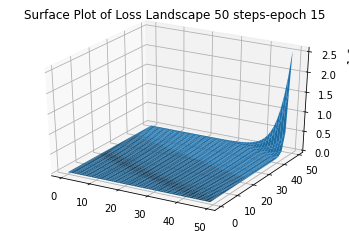

In [27]:
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin)
ax.set_title('Surface Plot of Loss Landscape 50 steps-epoch 15')
fig.show()

### Plot graphs

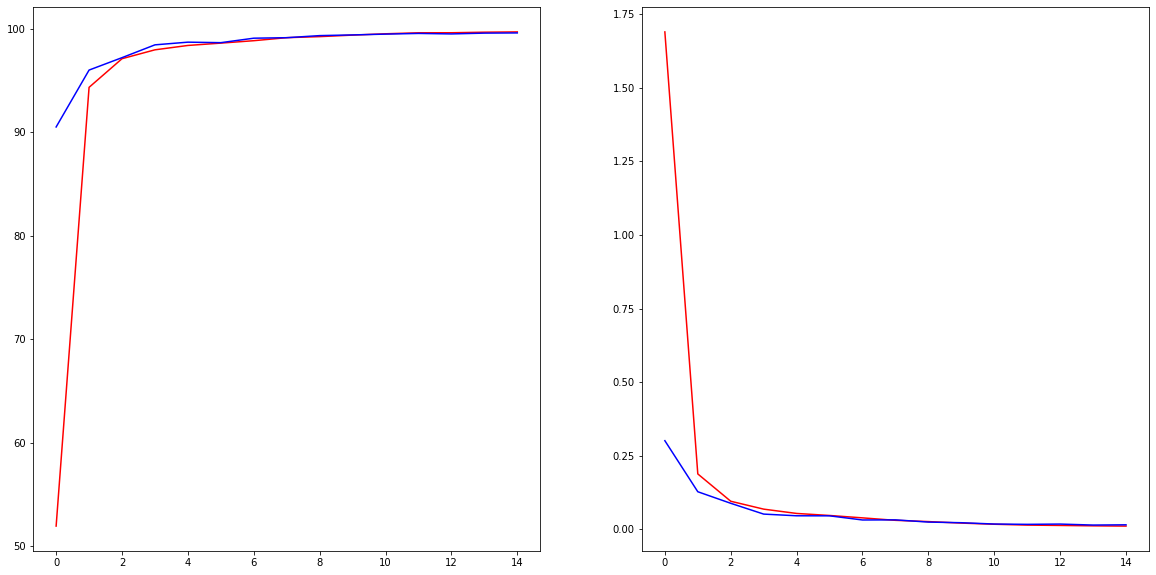

In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# X coordinate for plotting
x = np.arange(numEpoch)

plt.figure(figsize=(20,10))

# Train is red, validation is blue
plt.subplot(1,2,1)
plt.plot(x,train_accs,'r')
plt.plot(x,val_accs,'b')

plt.subplot(1,2,2)
plt.plot(x,train_losses,'r')
plt.plot(x,val_losses,'b')

plt.show()